In [1]:
import collections
import pandas as pd
import tensorflow as tf
import numpy as np

from sklearn.preprocessing import OneHotEncoder

import vae_lib.utils.nn_logger as log
from vae_lib.nn.simple_nn import SimpleNN
from vae_lib.nn.stochastic_nn_with_gmm import StochasticNNWithGmm
from vae_lib.graphics.plot_utils import plot_2d_latent_space
from vae_lib.preprocessing.data_permutation import permute
from vae_lib.utils.static_gmm_on_circle import StaticGmmOnCircle



from vae_lib.nn.dense_layer import DenseLayer
from vae_lib.utils.dynamic_gmm_on_circle import DynamicGmmOnCircle

Normal = tf.distributions.Normal
Bernoulli = tf.distributions.Bernoulli

In [2]:
base_path = "/Users/mjankowski/doc/data/reuters/for_python/"

In [3]:
reuters_data_train_all_bow = pd.read_csv(base_path+'reuters.data.train.csv').values
reuters_data_test_all_bow = pd.read_csv(base_path+'reuters.data.test.csv').values
reuters_labels_train_all = pd.read_csv(base_path+'reuters.labels.train.csv').values.reshape((-1,1))
reuters_labels_test_all = pd.read_csv(base_path+'reuters.labels.test.csv').values.reshape((-1,1))

In [4]:
#collections.Counter(reuters_labels_train_all.reshape(-1))

In [5]:
reuters_data_train_all = (reuters_data_train_all_bow >= 1.0).astype(np.float32)
reuters_data_test_all = (reuters_data_test_all_bow >= 1.0).astype(np.float32)

In [6]:
train_cond = ((reuters_labels_train_all == 1) | (reuters_labels_train_all == 2) | (reuters_labels_train_all == 3)).reshape(-1)
train_cond.shape

(11314,)

In [7]:
test_cond = ((reuters_labels_test_all == 1) | (reuters_labels_test_all == 2) | (reuters_labels_test_all == 3)).reshape(-1)
test_cond.shape


(7532,)

In [8]:
reuters_labels_train = reuters_labels_train_all[train_cond,:]
reuters_data_train = reuters_data_train_all[train_cond, :]

In [9]:
reuters_labels_test = reuters_labels_test_all[test_cond,:]
reuters_data_test = reuters_data_test_all[test_cond, :]

In [10]:
collections.Counter(reuters_labels_train.reshape(-1))

Counter({1: 480, 2: 584, 3: 591})

In [11]:
onehot_encoder = OneHotEncoder(sparse=False, categories='auto')
onehot_encoder.fit(reuters_labels_train)

OneHotEncoder(categorical_features=None, categories='auto',
       dtype=<class 'numpy.float64'>, handle_unknown='error',
       n_values=None, sparse=False)

In [12]:
reuters_labels_train_one_hot = onehot_encoder.transform(reuters_labels_train)
reuters_labels_test_one_hot = onehot_encoder.transform(reuters_labels_test)

In [13]:
reuters_data_train_perm, reuters_labels_train_one_hot_perm = permute(reuters_data_train,reuters_labels_train_one_hot)

In [14]:
#reuters_labels_train_one_hot_perm

In [16]:
tf.reset_default_graph()
log_folder = log.get_log_folder()
print("Writing logs to: {}".format(log_folder))
simple_nn = SimpleNN([2000, 512, 256, 3], learning_rate=1e-3, log_folder=log_folder)
simple_nn.fit(
    reuters_data_train_perm, 
    reuters_labels_train_one_hot_perm, 
    reuters_data_test, 
    reuters_labels_test_one_hot, 
    epochs=10, 
    log_interval=10
)

Writing logs to: /tmp/class_vae/deep/26_04_2019/20190426134827
Train accuracy: 97.4%
Test accuracy: 87.11%
Train accuracy: 99.4%
Test accuracy: 87.66%
Train accuracy: 99.4%
Test accuracy: 86.3%
Train accuracy: 99.27%
Test accuracy: 85.12%
Train accuracy: 99.52%
Test accuracy: 87.02%
Train accuracy: 98.49%
Test accuracy: 82.58%
Train accuracy: 99.64%
Test accuracy: 87.02%
Train accuracy: 99.15%
Test accuracy: 83.67%
Train accuracy: 98.01%
Test accuracy: 81.03%
Train accuracy: 97.52%
Test accuracy: 80.31%


In [18]:
#tf.reset_default_graph()
log_folder = log.get_log_folder()
print('Starting autoencoder. Log folder={}'.format(log_folder))

K=3
init_cov = np.array([
    [0.07,0.0],
    [0.0,0.007]
], dtype="float64")
betas = np.ones(K)/K


model_supervised = StochasticNNWithGmm(
    x_dim=reuters_data_train_perm.shape[1],
    y_dim=reuters_labels_train_one_hot_perm.shape[1],
    hidden_dims=[1024, 512, 256, 128, 2],
    log_folder=log_folder,
    alpha=0,
    beta=0,#0.1,
    gamma=1,
    omega=0.0001,
    r=0.8,
    K=K,
    init_cov=init_cov,
    mixture_weights=betas
)
model_supervised.fit(
    X_train=reuters_data_train_perm, 
    y_train=reuters_labels_train_one_hot_perm, 
    X_test=reuters_data_test,
    y_test=reuters_labels_test_one_hot,
    epochs=10,
    log_interval=10
)

test_acc = model_supervised.calculate_accuracy(X=reuters_data_test, y=reuters_labels_test_one_hot)
print("Test accuracy {}".format(test_acc))

Starting autoencoder. Log folder=/tmp/class_vae/deep/26_04_2019/20190426164658
Hidden shape: (?, 2)
self.posterior_predictive_probs_y.shape [None, 3]
self.y.shape [None, 3]
xy.shape [None, 2003]


/anaconda3/envs/vae_tests/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


n_batches: 25
epoch: 0
Train accuracy 0.5987915396690369
Test accuracy 0.5299455523490906
epoch: 1
Train accuracy 0.8809667825698853
Test accuracy 0.7840290665626526
epoch: 2
Train accuracy 0.9836857914924622
Test accuracy 0.8221415877342224
epoch: 3
Train accuracy 0.9927492737770081
Test accuracy 0.8049001693725586
epoch: 4
Train accuracy 0.9951661825180054
Test accuracy 0.819419264793396
epoch: 5
Train accuracy 0.9969788789749146
Test accuracy 0.8139746189117432
epoch: 6
Train accuracy 0.9975830912590027
Test accuracy 0.7985481023788452
epoch: 7
Train accuracy 0.9951661825180054
Test accuracy 0.774954617023468
epoch: 8
Train accuracy 0.9969788789749146
Test accuracy 0.8103448152542114
epoch: 9
Train accuracy 0.998791515827179
Test accuracy 0.819419264793396
Test accuracy 0.8157894611358643


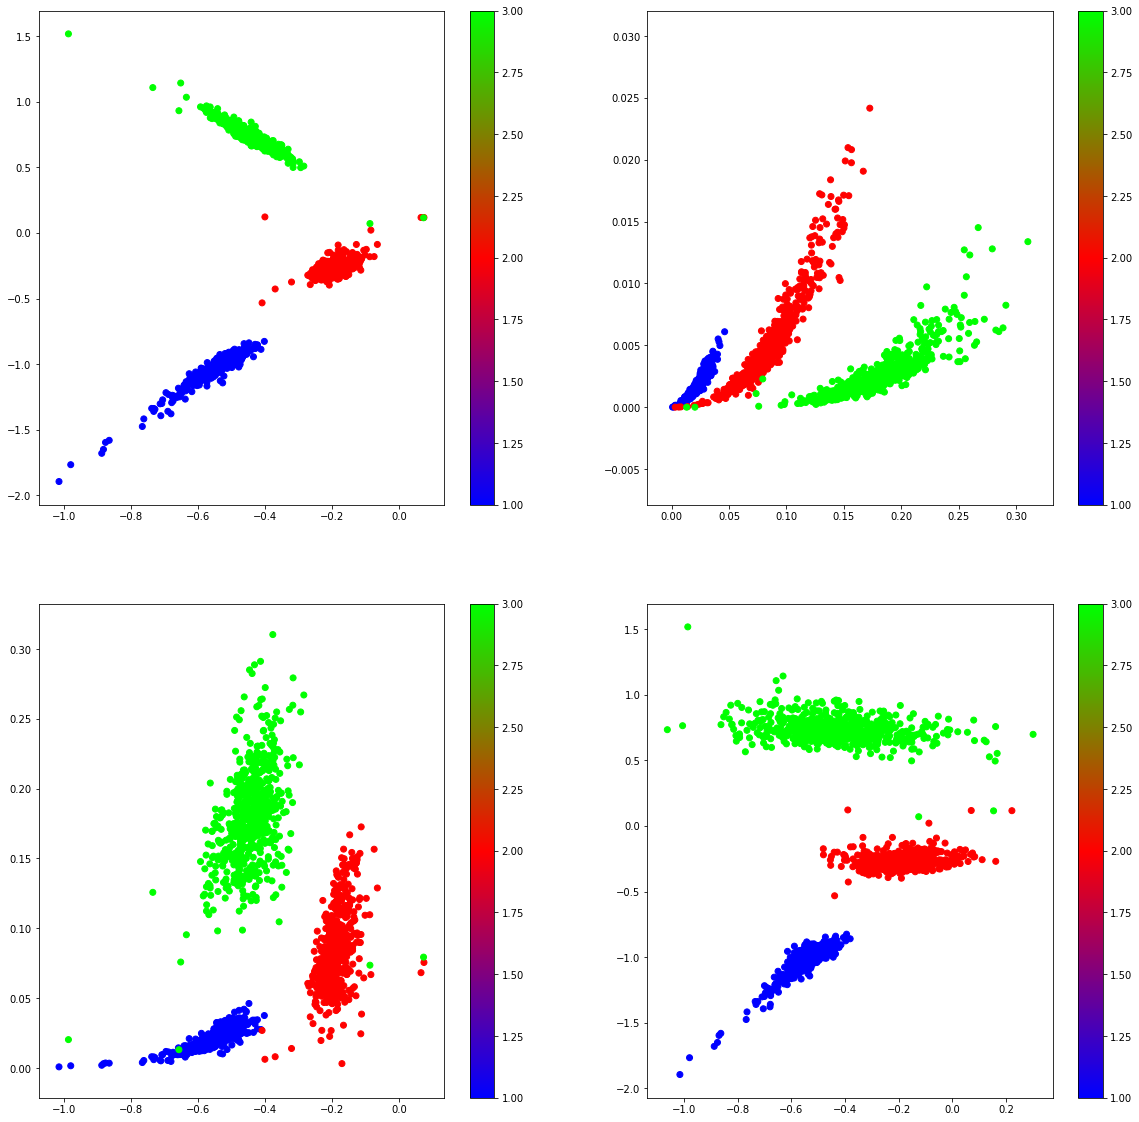

In [19]:
plot_2d_latent_space(model_supervised, onehot_encoder, reuters_data_train, reuters_labels_train_one_hot)

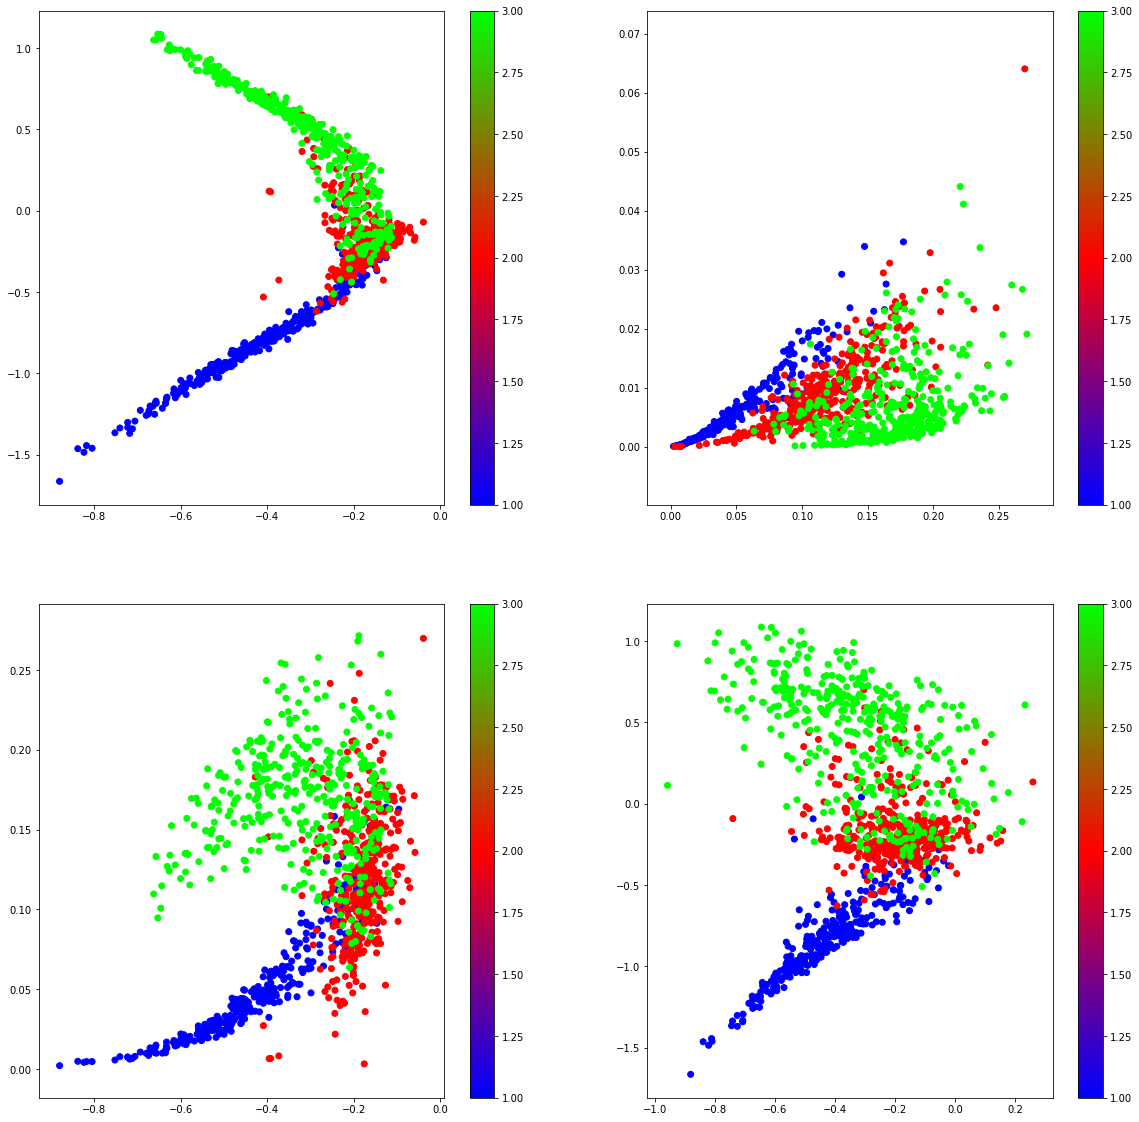

In [20]:
plot_2d_latent_space(model_supervised, onehot_encoder, reuters_data_test, reuters_labels_test_one_hot)

In [30]:
#tf.reset_default_graph()
log_folder = log.get_log_folder()
print('Starting autoencoder. Log folder={}'.format(log_folder))

init_cov = np.array([
    [0.07,0.0],
    [0.0,0.007]
], dtype="float64")

betas = np.ones(K)/K

model_supervised_latent_supervised = StochasticNNWithGmm(
    x_dim=reuters_data_train_perm.shape[1],
    y_dim=reuters_labels_train_one_hot_perm.shape[1],
    hidden_dims=[1024, 512, 256, 128, 2],
    log_folder=log_folder,
    alpha=0,
    beta=0,#0.1,
    gamma=1,
    omega=0.0001,
    r=0.8,
    K=3,
    init_cov=init_cov,
    is_latent_supervised=True,
    mixture_weights=betas
)
model_supervised_latent_supervised.fit(
    X_train=reuters_data_train_perm, 
    y_train=reuters_labels_train_one_hot_perm, 
    X_test=reuters_data_test,
    y_test=reuters_labels_test_one_hot,
    epochs=10,
    log_interval=10
)

test_acc = model_supervised_latent_supervised.calculate_accuracy(X=reuters_data_test, y=reuters_labels_test_one_hot)
print("Test accuracy {}".format(test_acc))

Starting autoencoder. Log folder=/tmp/class_vae/deep/27_04_2019/20190427153819
Hidden shape: (?, 2)
self.posterior_predictive_probs_y.shape [None, 3]
self.y.shape [None, 3]
xy.shape [None, 2003]


/anaconda3/envs/vae_tests/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


n_batches: 25
epoch: 0
Train accuracy 0.6990936398506165
Test accuracy 0.6370235681533813
epoch: 1
Train accuracy 0.9758307933807373
Test accuracy 0.819419264793396
epoch: 2
Train accuracy 0.9957703948020935
Test accuracy 0.8584392070770264
epoch: 3
Train accuracy 0.9975830912590027
Test accuracy 0.8593466281890869
epoch: 4
Train accuracy 0.998791515827179
Test accuracy 0.872958242893219
epoch: 5
Train accuracy 0.998791515827179
Test accuracy 0.8548094630241394
epoch: 6
Train accuracy 0.998791515827179
Test accuracy 0.8747731447219849
epoch: 7
Train accuracy 0.998791515827179
Test accuracy 0.8611615300178528
epoch: 8
Train accuracy 0.998791515827179
Test accuracy 0.8611615300178528
epoch: 9
Train accuracy 0.998791515827179
Test accuracy 0.8675135970115662
Test accuracy 0.8666061758995056


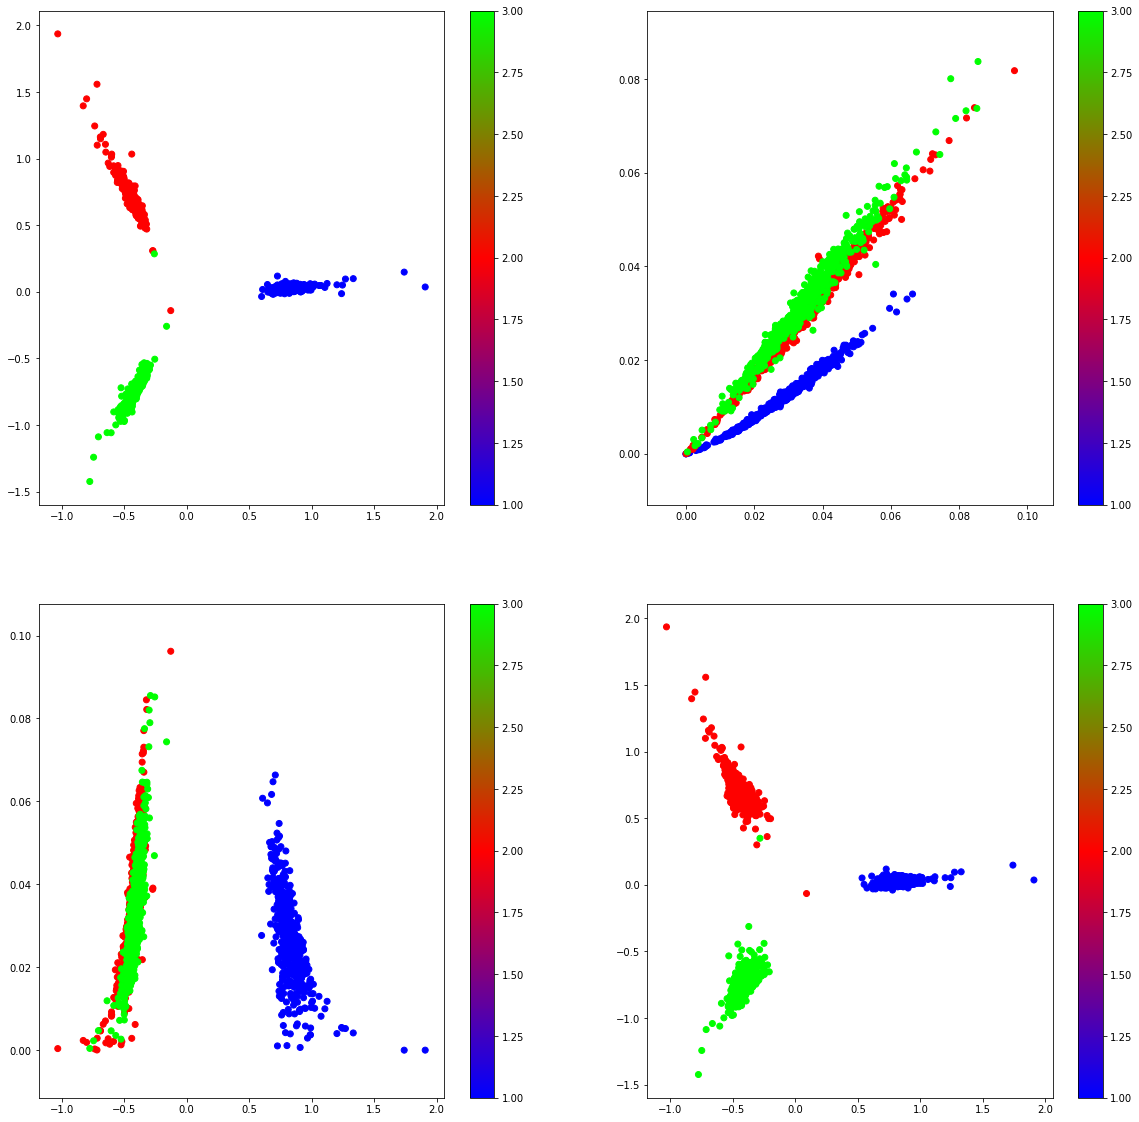

In [31]:
plot_2d_latent_space(model_supervised_latent_supervised, onehot_encoder, reuters_data_train, reuters_labels_train_one_hot)


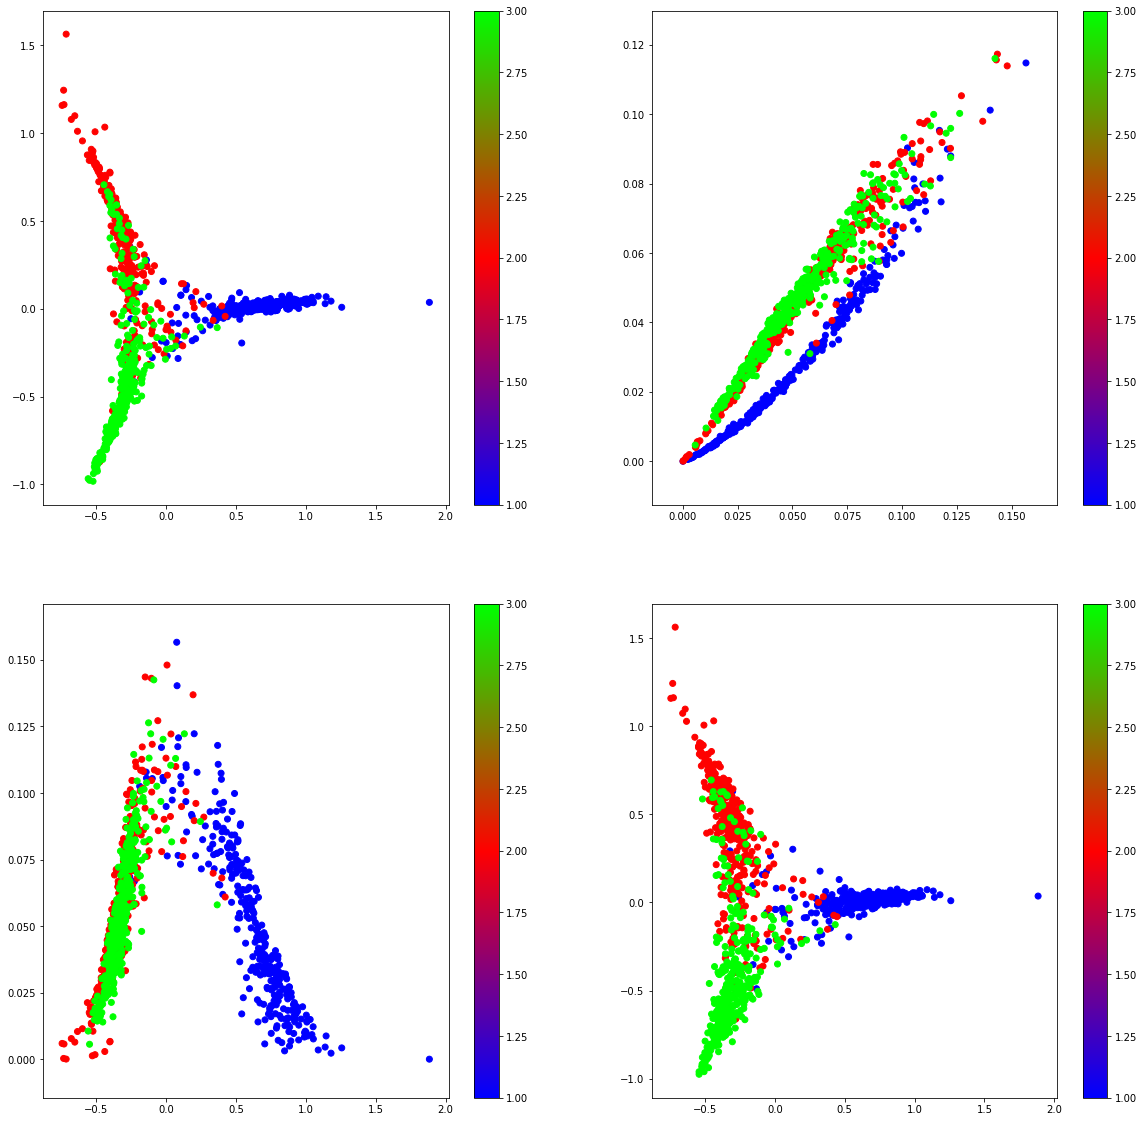

In [32]:
plot_2d_latent_space(model_supervised_latent_supervised, onehot_encoder, reuters_data_test, reuters_labels_test_one_hot)